# Project 2: Reproducibility in Natural Language Processing



## Part 1: Data Loading and Initial Exploration (15 pts)

The data for this project is stored in the `data` folder in your repositories, in the `SOTU.csv` file. The data file is structured as a CSV with columns for president name, speech text, year, and word count in the speech. 

In this section you will:

1. Import the data into a pandas dataframe
2. Perform exploratory data analysis (EDA) including specifically:
- Analyze the number of speeches per president
- Analyze the number of speeches per year
- Analyze the word count distribution
- Analyze the word count distribution accross years using a rug plot
- Analyze the average word count per president
3. Write commentary on your findings

First, create the `conda` environment with the provided yaml file. Note, it's not unusual for it to take ~15 minutes for the environment to fully install.

### Read Data

In [5]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark')
sou = pd.read_csv("data/SOTU.csv")
sou

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
...,...,...,...,...
241,George Washington,1791.0,\nFellow-Citizens of the Senate and House of R...,2264
242,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
243,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
244,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069


### Exploratory Data Analysis

Replicate the plots below using the hints specified. For each plot, provide some commentary describing the results/anything interesting you might see.

#### Number of Speeches per President

In [2]:
# Hint - use value_counts() on the President column
# Hint - sort in order of dataframe
speeches_per_pres = sou["President"].value_counts().reindex(sou["President"].drop_duplicates())

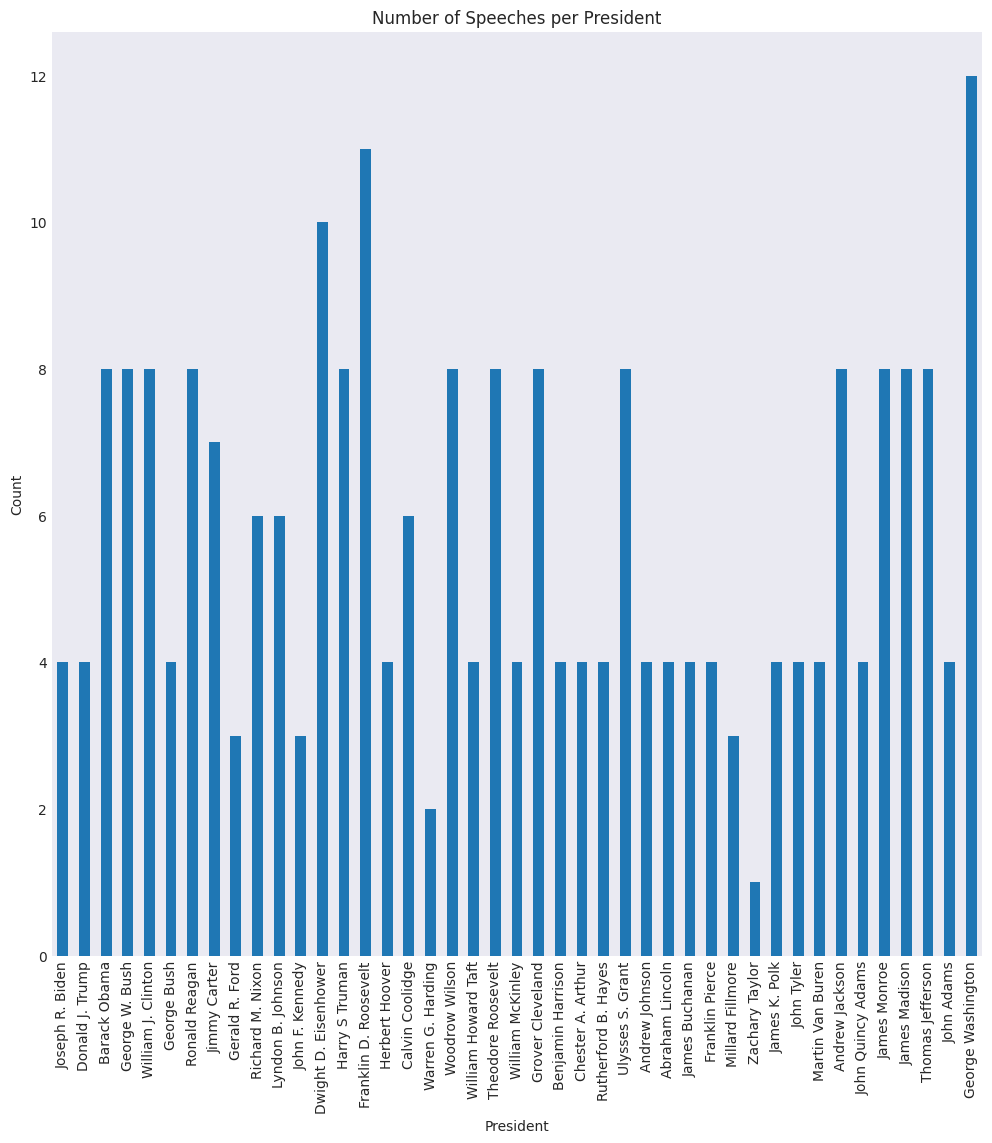

In [3]:
# Plot 
# Hint - use the .plot() method for Pandas Series, make sure all presidents show up on x-axis
speeches_per_pres.plot(kind="bar",figsize=(12, 12))
plt.title("Number of Speeches per President")
plt.xlabel("President")
plt.ylabel("Count")
plt.savefig('outputs/01-01_Speeches per president.png')

#### Number of Speeches per Year

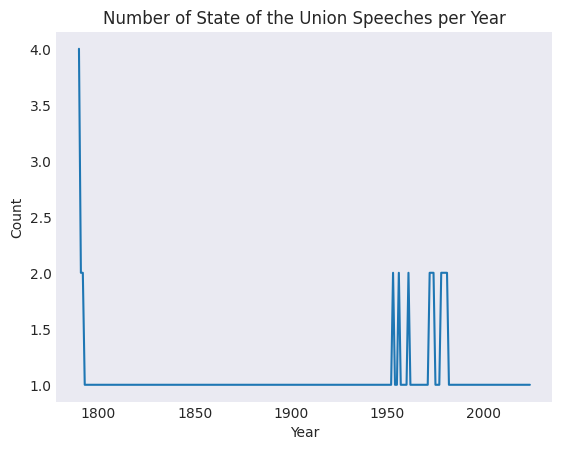

In [4]:
# Hint - Use value counts and sort by years
speeches_per_year = sou["Year"].value_counts().sort_index()
speeches_per_year.plot()  
plt.title("Number of State of the Union Speeches per Year")
plt.xlabel("Year")
plt.ylabel("Count");
plt.savefig('outputs/01-02_SOTU speeches per year.png')

#### Word Count Distribution 

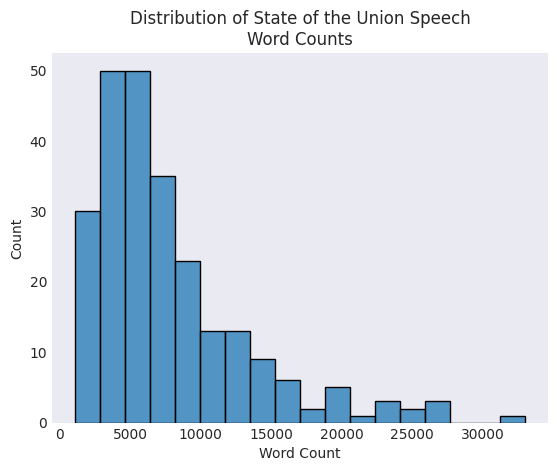

In [5]:
# Hint - try seaborn.histplot()
sns.histplot(sou["Word Count"])

plt.title("Distribution of State of the Union Speech\nWord Counts")
plt.xlabel("Word Count")
plt.ylabel("Count")
plt.savefig('outputs/01-03_SOTU speech word count distribution.png')

#### Word Count Distribution over Year

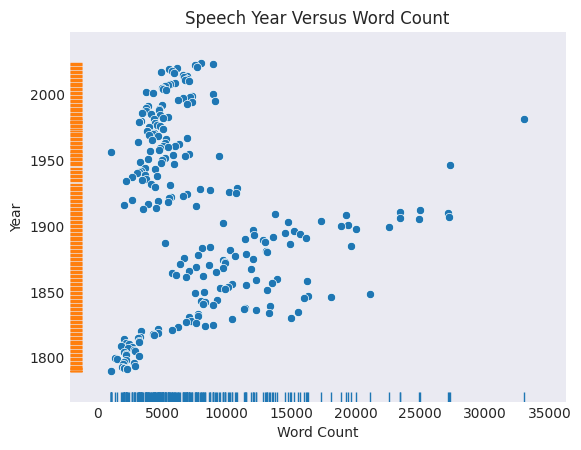

In [6]:
# Hint: try seaborn.rugplot()
sns.scatterplot(data=sou, x="Word Count", y="Year")

sns.rugplot(data=sou, x="Word Count")
sns.rugplot(data=sou, y="Year")

plt.title("Speech Year Versus Word Count")
plt.xlabel("Word Count")
plt.ylabel("Year");
plt.savefig('outputs/01-04_Speech year versus word count.png')

#### Word Count Distribution per President

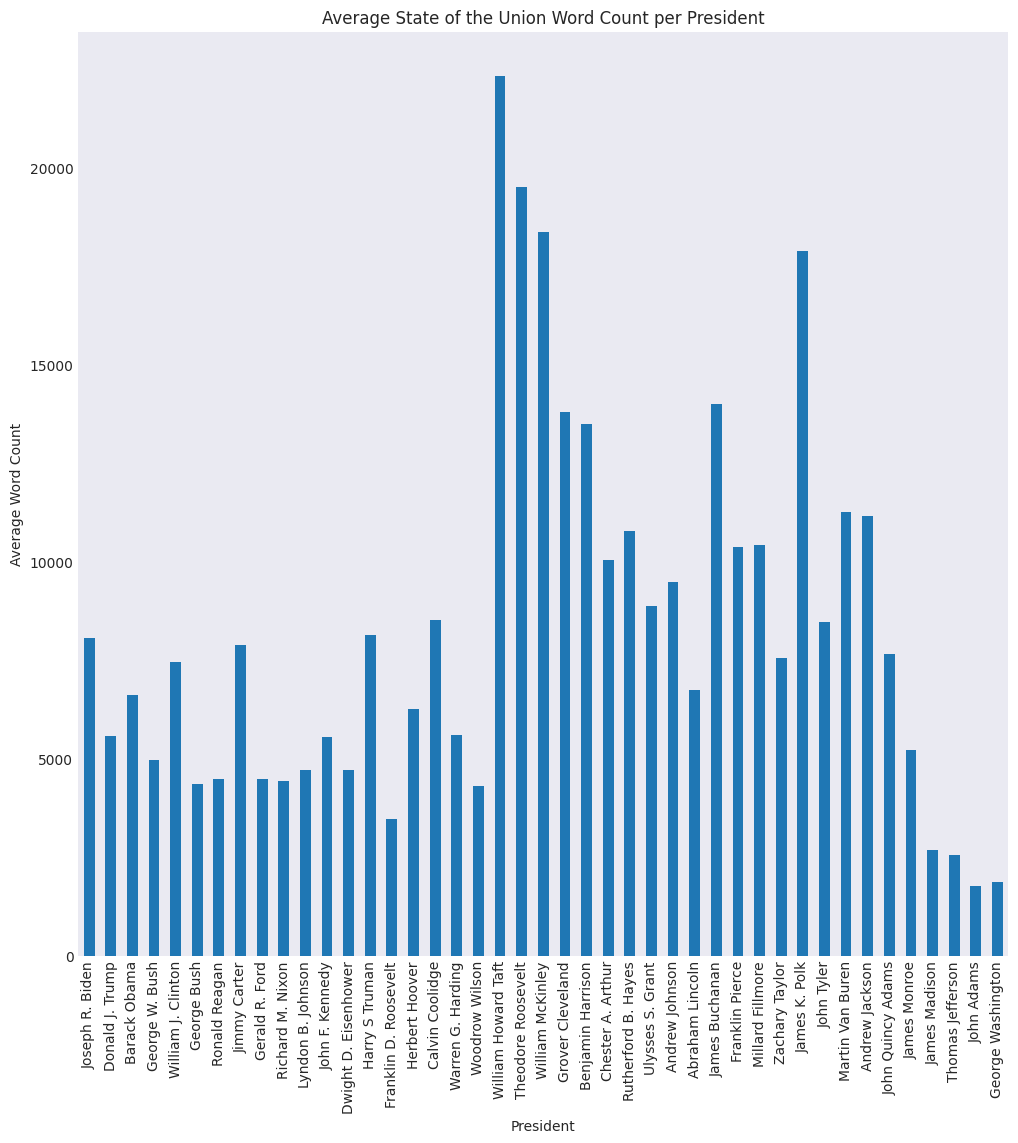

In [7]:
# Hint: use pandas groupby to get mean word count per president then sort by order
avg_wc = sou.groupby("President")["Word Count"].mean().reindex(sou["President"].drop_duplicates())

plt.figure()
ax = avg_wc.plot(kind="bar",figsize=(12, 12))

ax.set_title("Average State of the Union Word Count per President")
ax.set_xlabel("President")
ax.set_ylabel("Average Word Count")
plt.savefig('outputs/01-05_Average SOTU word count per president.png')

## Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization (20 pts)

Now we will start working on simple text processing using the `SpaCy` package and the same dataset as Part 1. The package should already be included in the `environment.yml`. However, we will also need to download `en_core_web_sm`, an English language text processing model. To do this, while having your `sotu` environment activated, run the following:

```
python -m spacy download en_core_web_sm
```

Now, you should be good to go!

Some important definitions:

- *Token*: a single word or piece of a word
- *Lemma*: the core component of a word, e.g., "complete" is the lemma for "completed" and "completely"
- *Stop Word*: a common word that does not add semantic value, such as "a", "and", "the", etc.
- *Vectorization*: representing a document as a vector where each index in the vector corresponds to a token or word and each entry is the count.

In this section, we will explore the most common tokens and lemmas throughout different slices of the speech data. We will also develop vectorization representations of the speeches. 

 The core steps are:

1. Process speeches using the SpaCy nlp module
2. Analyze Tokens vs Lemmas:
- Create a list of all tokens across all speeches that are not stop words, punctuation, or spaces.
- Create a second list of the lemmas for these same tokens.
- Display the top 25 for each of these and compare.
3. Analyze common word distributions over different years:
- Create a function that takes the dataset and a year as an input and outputs the top n lemmas for that year's speeches
- Compare the top 10 words for 2023 versus 2019
4. Document Vectorization:
- Train a Term Frequency-Inverse Document Frequency (TF-IDF) vectorization model using your processed dataset and scikit learn
- Output the feature vectors 

**Helpful Resources:**
- https://realpython.com/natural-language-processing-spacy-python/
- https://www.statology.org/text-preprocessing-feature-engineering-spacy/ 
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html# 
- https://www.geeksforgeeks.org/nlp/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/ 



### Processing Speeches with SpaCy

Lets study just speeches from 2000 and onwards to begin with. So, be sure to subset your DataFrame to just these speeches before continuing!

In [7]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

In [9]:
# subset the speech dataframe for speeches from 2000 and onwards
sou_2000 = sou[sou["Year"] >= 2000]
sou_2000

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
5,Donald J. Trump,2019.0,"\nThe President. Madam Speaker, Mr. Vice Presi...",5519
6,Donald J. Trump,2018.0,"\nThe President. Mr. Speaker, Mr. Vice Preside...",5755
7,Donald J. Trump,2017.0,"\nThank you very much. Mr. Speaker, Mr. Vice P...",4903
8,Barack Obama,2016.0,"\nThank you. Mr. Speaker, Mr. Vice President, ...",5956
9,Barack Obama,2015.0,"\nThe President. Mr. Speaker, Mr. Vice Preside...",6659


In [10]:
# Process each speeches using the 'nlp' function
# Hint - loop through each speech and pass the text into the nlp function above, storing the output in a list
# should take about 30 seconds to process

processed_speeches = []
for text in tqdm(sou_2000["Text"], desc="Processing speeches"):
    doc = nlp(text)
    processed_speeches.append(doc)

Processing speeches: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


### Analyze Tokens vs Lemmas

#### Token List

Create a list of tokens across all speeches that are not spaces, stopwords, or punctuation. Make each token lowercase as well. *Hint: each element of the list we just created are themselves lists of tokens. Token objects have attributes `is_stop`, `is_punct`, and `is_space`.*


In [11]:
all_tokens = []
for doc in processed_speeches:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_tokens.append(token.text.lower())     

In [12]:
# print top 20 tokens
# Hint - use Counter, and one of the Counter object's methods to display the top 20
top_20_tokens = Counter(all_tokens).most_common(20)
top_20_tokens

[('america', 816),
 ('people', 637),
 ('american', 582),
 ('new', 530),
 ('years', 439),
 ('americans', 437),
 ('world', 425),
 ('year', 406),
 ('country', 369),
 ('jobs', 348),
 ('tonight', 344),
 ('work', 324),
 ('know', 323),
 ('let', 320),
 ('congress', 317),
 ('nation', 311),
 ('time', 301),
 ('help', 282),
 ('need', 266),
 ('tax', 255)]

#### Lemma List

Do the same as above, but for lemmas. *Hint: recall lemmas are components of words. Each token should have an attribute to extract the lemma.*

In [13]:
all_lemmas = []  
for doc in processed_speeches:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_lemmas.append(token.lemma_.lower()) 

top_20_lemmas = Counter(all_lemmas).most_common(20)
top_20_lemmas

[('year', 845),
 ('america', 816),
 ('people', 639),
 ('american', 587),
 ('work', 557),
 ('new', 532),
 ('job', 486),
 ('country', 435),
 ('americans', 432),
 ('world', 426),
 ('know', 395),
 ('nation', 388),
 ('help', 378),
 ('need', 353),
 ('time', 351),
 ('tonight', 344),
 ('child', 332),
 ('let', 326),
 ('congress', 317),
 ('come', 301)]

#### Token versus Lemma Comparison

Comparing the top 20 tokens with the top 20 lemmas, the most noticable difference is that the lemma 'year' rises to first place because the counts of 'year' and 'years' are combined. Consequently, lemmas such as 'child' and 'come' appear in the top 20 lemma list even though their tokens didn't. Conversely, the token 'tax' doesn't appear in the top 20 lemma list because it doesn't gain additional frequency from combing multiple word forms.

### Common Words

#### Common Words per Year Function

Fill in the below function to obtain the n-most common words in speeches for a given year.

inputs: 
- df raw unprocessed sou dataframe
- year
- n
outputs: 
- top n words for that years

steps:
- subset the dataframe for the year of interest - note the years might not be in int type
- process the subsetted dataframe with spacy
- get the lemmas across all those speeches
- count the top n lemmas

In [14]:
def get_most_common_words(df, year, n=25):
    """
    Processes the SOTU speech for a given year and returns
    the most common non-stopword/punctuation lemmas.
    """

    # Step 1: Subset df
    year_df = df[df["Year"] == year]
    # Step 2: Process the text with spaCy
    lemmas = [] 
    for text in year_df["Text"]:
        doc = nlp(text)  
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.is_space:
                lemmas.append(token.lemma_.lower())
    # Step 3: Get lemmas
    most_common = Counter(lemmas).most_common(n)

    return most_common

In [15]:
# test it on 2024
words_2024 = get_most_common_words(sou, 2024, n=20)
words_2024

[('president', 58),
 ('year', 45),
 ('america', 44),
 ('american', 34),
 ('people', 33),
 ('$', 33),
 ('member', 32),
 ('want', 29),
 ('audience', 29),
 ('know', 29),
 ('pay', 29),
 ('come', 26),
 ('home', 25),
 ('family', 24),
 ('future', 23),
 ('million', 23),
 ('like', 21),
 ('build', 21),
 ('laughter', 20),
 ('americans', 20)]

#### Compare 2023 to 2017

Run your function from the previous step to get the top 20 words for 2017 and 2023. Plot the words and their frequencies in a barchart and replicate the figure below.

In [16]:
words_2023 = get_most_common_words(sou, 2023, n=20)
words_2017 = get_most_common_words(sou, 2017, n=20)

In [17]:
words_2023

[('year', 58),
 ('go', 56),
 ('let', 45),
 ('know', 40),
 ('people', 39),
 ('job', 38),
 ('america', 36),
 ('come', 33),
 ('law', 33),
 ('pay', 33),
 ('american', 31),
 ('$', 31),
 ('president', 30),
 ('look', 27),
 ('world', 25),
 ('folk', 24),
 ('nation', 24),
 ('audience', 23),
 ('work', 23),
 ('right', 23)]

In [18]:
words_2017

[('american', 34),
 ('america', 29),
 ('country', 26),
 ('nation', 21),
 ('great', 20),
 ('new', 19),
 ('year', 19),
 ('world', 18),
 ('job', 15),
 ('people', 15),
 ('americans', 14),
 ('united', 13),
 ('tonight', 13),
 ('states', 12),
 ('work', 12),
 ('child', 12),
 ('want', 12),
 ('time', 12),
 ('citizen', 11),
 ('right', 11)]

In [19]:
# Hint - put the words and counts into a pd Dataframe for better structure
# and to make plotting easier
df_2017 = pd.DataFrame(words_2017, columns=["Lemma", "Count"])
df_2017.set_index("Lemma", inplace=True)

df_2023 = pd.DataFrame(words_2023, columns=["Lemma", "Count"])
df_2023.set_index("Lemma", inplace=True)

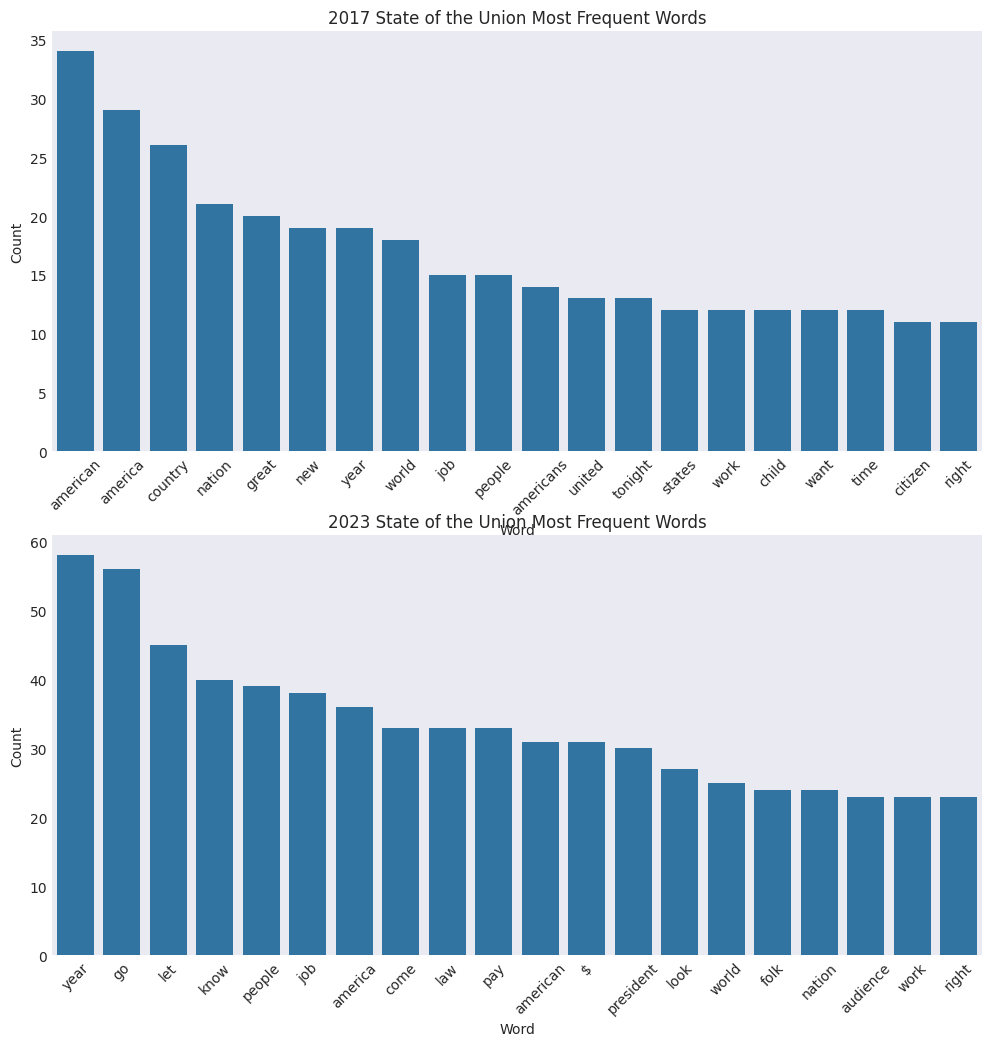

In [20]:
# Hint - use seaborn, subplots, and rotate tick labels
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))

# 2017
sns.barplot(x=df_2017.index, y=df_2017["Count"], ax=axes[0])
axes[0].set_title("2017 State of the Union Most Frequent Words")
axes[0].set_xlabel("Word")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=45)


# 2023
sns.barplot(x=df_2023.index, y=df_2023["Count"], ax=axes[1])
axes[1].set_title("2023 State of the Union Most Frequent Words")
axes[1].set_xlabel("Word")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=45)

### TF-IDF Vectorization

To use statsitical alorithms on documents, we need to transform them into vectors, where each element of the vector corresponds to a particular word in a document or corpus of documents. One common way is via TF-IDF embeddings. LLMs work similarly - they typically use transformer models to generate text embeddings before sending text through a deep neural network. 

Here we will fit a TF-IDF vectorizer, plot all the speeches on a 2-D grid using PCA and also using a heatmap, and examine TF-IDF scores for the top 10 most common words in the first speech. This is a good resource here: https://medium.com/GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d 

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#### Train the Vectorizer and Transform the Data

In [22]:
# you may use this as input to fit the TF-IDF vectorizer
raw_docs = sou["Text"].to_list()

In [23]:
# Hint - use fit_transform for vectorizer and PCA
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(raw_docs).toarray()

The output of `fit_transform()` will be a matrix where each row corresponds to a speech, each column corresponds to a word in the corpus of speeches, and the value is the TF-IDF score which measures the importance of that word in that speech, relative to the rest of the speeches.

#### Plot Speeches

- First used PCA to generate the first chart
- Second use seaborn heatmap with a log-scaled color axis to generate the second chart

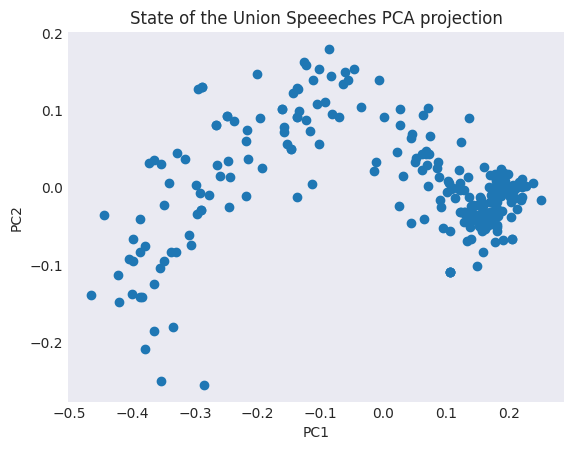

In [24]:
# Step 1: Set PCA to find first 2 principal components
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(tfidf)
# Step 2: Create a new dataframe where each row is a speech, and each column is a projection onto
# one of the two principal components
pca_df = pd.DataFrame(pca_result, columns = ['PC1', 'PC2'])
# Plot Data Visualization (Matplotlib)
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('State of the Union Speeeches PCA projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('outputs/02-01_PCA projection.png')

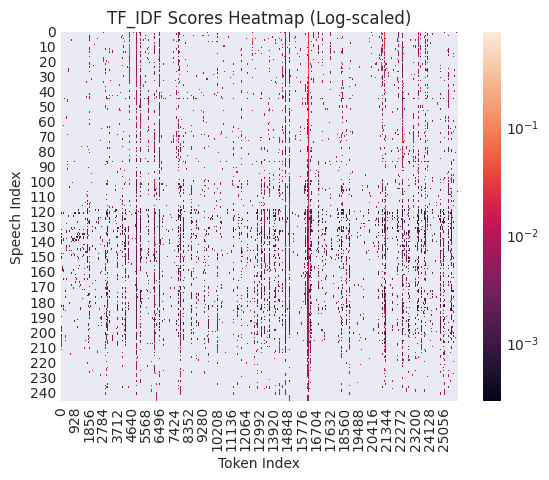

In [25]:
# Hint - vectorized_docs is a sparse matrix whose rows are speeches and columns are tokens, with each
# value being a TF-IDF score. Densify this array first, and then plot using seaborn.
tfidf_df = pd.DataFrame(tfidf)
sns.heatmap(tfidf_df, norm=plt.matplotlib.colors.LogNorm())
plt.title('TF_IDF Scores Heatmap (Log-scaled)')
plt.xlabel('Token Index')
plt.ylabel('Speech Index')
plt.savefig('outputs/02-02_TF_IDF scores heatmap.png')

#### Get the TF-IDF value for certain words and documents

In [26]:
word_list = ['year',
 'america',
 'people',
 'american',
 'work',
 'new',
 'job',
 'country',
 'americans',
 'world'] # top ten most common words through whole corpus

In [27]:
word_nums = [vectorizer.vocabulary_[word] for word in word_list] # get each word's index number
idf_score = [vectorizer.idf_[i] for i in word_nums]

In [28]:
tf_idf = tfidf[0, [i for i in word_nums]] # get the tf_idf score for the first speech

In [29]:
pd.DataFrame({"Word": word_list, "IDF Score": idf_score, "TF-IDF Score": tf_idf})

,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438


## Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)

**Resources:**
- LDA:
    - https://medium.com/sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06 
    - https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%9A-Topic-Modeling (code for previous post)
    - https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf/ 
- BERTopic:
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_documents.html#visualize-documents-with-plotly 
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html 


In [2]:
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

/home/jovyan/.local/share/envs/sotu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LDA

- Train an LDA model with 18 topics
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization

You may use the next two cells to process the data.

In [3]:
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [8]:
# Process all texts - note this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

To train an LDA model, use the LdaModel function that we imported a couple of cells back. The last resource linked under the LDA section is especially useful for walking through the steps we have below. *Note: one of the arguments to the LdaModel function is `random_state` which specifies the random seed for reproducibility. Please set yours to 42. Further, the last resource provided uses `LdaMulticore` which is essentially a parallelizable version of our function `LdaModel`. Use `LdaModel` instead, but the usage will be similar, except you can ignore the `iterations` and `workers` arguments..*.

In [9]:
processed_docs

0      [speak, president, present, prepared, remark, ...
1      [president, speaker, point, president, turn, f...
2      [president, thank, thank, thank, madam, speake...
3      [president, thank, thank, thank, good, mitch, ...
4      [president, thank, thank, thank, madam, speake...
                             ...                        
241    [fellow, citizen, senate, house, representativ...
242    [fellow, citizen, senate, house, representativ...
243    [fellow, citizen, senate, house, representativ...
244    [fellow, citizen, senate, house, representativ...
245    [fellow, citizen, senate, house, representativ...
Name: Text, Length: 246, dtype: object

In [10]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
# This results in 22652 unique tokens
# Question: should I filter out extreme value tokens?
sou['tokens'] = processed_docs
dictionary = Dictionary(sou['tokens'])

#dictionary = Dictionary(processed_docs)

In [11]:
# train LDA model with 18 topics

corpus = [dictionary.doc2bow(doc) for doc in sou['tokens']]
#corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=18, passes=10, random_state = 42)

In [12]:
# print the top 10 words for each topic
lda_model.print_topics()

[(0,
  '0.013*"states" + 0.013*"government" + 0.009*"united" + 0.008*"congress" + 0.007*"country" + 0.006*"year" + 0.006*"public" + 0.006*"great" + 0.005*"state" + 0.005*"power"'),
 (1,
  '0.002*"year" + 0.002*"people" + 0.002*"government" + 0.001*"states" + 0.001*"congress" + 0.001*"country" + 0.001*"nation" + 0.001*"great" + 0.001*"time" + 0.001*"united"'),
 (2,
  '0.003*"year" + 0.003*"government" + 0.002*"states" + 0.002*"congress" + 0.002*"united" + 0.002*"people" + 0.002*"great" + 0.002*"service" + 0.002*"public" + 0.001*"increase"'),
 (3,
  '0.015*"year" + 0.011*"world" + 0.011*"people" + 0.011*"america" + 0.010*"nation" + 0.007*"help" + 0.007*"congress" + 0.007*"american" + 0.007*"work" + 0.006*"time"'),
 (4,
  '0.009*"isthmus" + 0.006*"colombia" + 0.005*"government" + 0.004*"states" + 0.004*"panama" + 0.004*"united" + 0.004*"colombian" + 0.004*"treaty" + 0.003*"year" + 0.003*"congress"'),
 (5,
  '0.003*"year" + 0.002*"government" + 0.002*"nation" + 0.001*"united" + 0.001*"coun

In [13]:
# print the topic distribution for the first speech
lda_model[corpus][0]

[(7, np.float32(0.9997309))]

In [14]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [15]:
pyLDAvis.save_html(lda_display,'outputs/03_01_LDA_topics.html')

### BERTopic

- Train a BERTopic model with a `min_topic_size` of 3 *Hint: use `BERTopic` to instantiate the model and specify `min_topic_size` in here. Actually fit the model using `fit_transform`, which `docs` passed into this.*
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization of the topics (see topic_model.visualize_topics())

In [16]:
docs = sou['Text'].to_list()

In [ ]:
# train the model - this takes about 30 seconds
topic_model = BERTopic(min_topic_size=3)
topics, probs = topic_model.fit_transform(docs)

# remove stop words from the topics (Hint: use CountVectorizer and then .update_topics on topic_model)
vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [ ]:
# output the top 10 words for each topic - hint see get_topic_info
topic_model.get_topic_info()['Representation']

In [ ]:
# output the topic distribution for the first speech
# hint: check out approximate_distribution() and visualize_distribution()
topic_distr, _ = topic_model.approximate_distribution(docs)
first_speech = topic_model.visualize_distribution(topic_distr[1])

#save first speech topic distribution to outputs
first_speech.write_html("outputs/03_02_BERTopic_first_speech.html")
first_speech

In [ ]:
# run this cell to visualize the topics
topic_model.visualize_topics()

## Part 4: Choose your own advecnture! (7 Points; Optional for Extra Credit)

This section is open ended and your chance to explare any advanced analysis. Please perform any additional analysis you find interesting! Suggested analyses (only do one max):

- Topic evolution over time - see https://maartengr.github.io/BERTopic/getting_started/topicsovertime/topicsovertime.html#visualization 
- Word frequency over time - does the frequency of certain words change over time
- Semantic similarity - investigate similarity within and between presidents or time periods. For example, similarity between one presidents speeches, e.g. are all of Biden's speeches similar to each other? How similar are they to Trump's speeches? Are speeches from the 2000s more similar to each other than speeches in the 1800s? Which two presidents have the most similar speeches? See https://spacy.io/usage/linguistic-features#vectors-similarity 
-  Named Entity Recognition - which entity types are most common in speeches? What are the most common words for each entity type - see https://spacy.io/usage/linguistic-features#named-entities 
- Classification - can you build a classifier to detect democratic versus republican state of the union speeches from 1980-2024 - see https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py 
